# Test ESN Growth Rate Model

First, we connect to our Google Drive, where the model is stored

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls 'gdrive/My Drive/'

'2019-04-11 18-17.pdf'			   ESN_levels.hdf5
 8-8-ESN-G.hdf5				  'Fall 2017'
 8-8-ESN-L.hdf5				  'Freshman Year'
 8-8growth_rate.ipynb			   Grades
 8-8-LSTM-G.hdf5			  'Growth Test.ipynb'
 amazon.txt				   IMG_1422.JPG
'APAM Mentor Application 2019-2020.gdoc'  'Lowe Institute'
 Career					   lstm_growth1_weights.hdf5
'CHEN RICHY Photo.JPG'			   lstm_growth.hdf5
 clouderizer				  'Markets NN Pitch.gslides'
'Code Translation Project'		   new_growth.csv
'Colab Notebooks'			   Philosophy
'Derivatives MG Case.gdoc'		   QQtrader
 Echo_State_Networks.ipynb		  'Quotes Thoughts.gdoc'
'ESN 8-8growth_rate.ipynb'		  'Salvatori Center'
 ESN-8-to-8levels.ipynb			   Schedules.gsheet


Then, we define all the functions we need to test the model 5 ways:


*   Invest in only the most predicted growth rate asset every day
*   Invest evenly in all the predicted positive growth rate assets every day
*   Invest in only one asset when there is predicted positive growth
*   Invest or short only one asset depending on the predicted growth
*   Invest or short all assets depending on the predicted growth



In [0]:
"""
  Takes a model and simulates using the model to trade since 1987
"""

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras import backend as K
from numpy import concatenate
from numpy import append
from numpy import array
from numpy import nan

MODEL = "gdrive/My Drive/8-8-LSTM-G.hdf5"

def sign_ae(x, y):
    sign_x = K.sign(x)
    sign_y = K.sign(y)
    delta = x - y
    return sign_x * sign_y * K.abs(delta)


def linex_loss(delta, a=-1, b=1):
    if a!= 0 and b > 0:
        loss = b * (K.exp(a * delta) - a * delta - 1)
        return loss
    else:
        raise ValueError


def linex_loss_val(y_true, y_pred):
    delta = sign_ae(y_true, y_pred)
    res = linex_loss(delta)
    return K.mean(res)


def linex_loss_ret(y_true, y_pred):
    diff_true = y_true[1:] - y_true[:-1]
    diff_pred = y_pred[1:] - y_pred[:-1]

    delta = sign_ae(diff_true, diff_pred)
    res = linex_loss(delta)
    return K.mean(res)

def get_data():
    data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/richychn/market-modeling/master/static/data/growth_rate.csv')
    data = data.apply(pd.to_numeric, errors = "coerce")
    data['spindx'].replace(0, nan, inplace=True)
    data['spindx'].fillna(method='ffill', inplace=True)

    values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU']
                  + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
    values = values.astype('float32')
    return values

def data_setup(values, day):
    historic_data = array([])
    timestep = 10
    for growth in values[day:day+timestep]:
        historic_data = concatenate((historic_data, growth), axis=None)

    return historic_data.reshape(1,timestep,8)

def test_single_investment():
    values = get_data()
    K.clear_session()
    multi_model = load_model(MODEL, custom_objects={'linex_loss_val': linex_loss_val})

    investments = []
    graph = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        pred_para = data_setup(values, day)

        yhat = multi_model.predict(pred_para)
        yhat_pred = yhat.reshape(10,8)
        best_so_far = 0
        asset = -1
        for num, growth in enumerate(yhat_pred[0]):
            if growth > best_so_far:
                best_so_far = growth
                asset = num
        if best_so_far > 0:
            earn = earn * (1 + values[day + 10][asset])
        investments.append(asset)
        graph.append(earn)
        day += 1
    return earn, investments, graph
  
def test_multiple_investment():
    values = get_data()
    K.clear_session()
    multi_model = load_model(MODEL, custom_objects={'linex_loss_val': linex_loss_val})

    investments = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        pred_para = data_setup(values, day)

        yhat = multi_model.predict(pred_para)
        yhat_pred = yhat.reshape(10,8)
        for num, growth in enumerate(yhat_pred[0]):
            current = []
            if growth > 0:
                current.append(num)
        if len(current) == 0:
            invest = 0
        else:
            invest = earn / len(current)
            earn = 0
        for asset in current:
            earn += invest * (1 + values[day + 10][asset])
        investments.append(current)
        day += 1
    return earn, investments
  
def test_asset_investment(asset=0):
    values = get_data()
    K.clear_session()
    multi_model = load_model(MODEL, custom_objects={'linex_loss_val': linex_loss_val})

    investments = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        pred_para = data_setup(values, day)

        yhat = multi_model.predict(pred_para)
        yhat_pred = yhat.reshape(10,8)

        if yhat_pred[0][asset] > 0:
            earn = earn * (1 + values[day+10][asset])
        day += 1
    return earn
  
def test_short_investment(asset=0):
    values = get_data()
    K.clear_session()
    multi_model = load_model(MODEL, custom_objects={'linex_loss_val': linex_loss_val})

    investments = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        pred_para = data_setup(values, day)

        yhat = multi_model.predict(pred_para)
        yhat_pred = yhat.reshape(10,8)

        if yhat_pred[0][asset] > 0:
            earn = earn * (1 + values[day+10][asset])
        else:
            earn = earn * (1 - values[day+10][asset])
        day += 1
    return earn
  
def test_all_short_investment(asset=0):
    values = get_data()
    K.clear_session()
    multi_model = load_model(MODEL, custom_objects={'linex_loss_val': linex_loss_val})

    investments = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        pred_para = data_setup(values, day)

        yhat = multi_model.predict(pred_para)
        yhat_pred = yhat.reshape(10,8)
        invest = earn / 8
        earn = 0
        for asset in range(8):
            if yhat_pred[0][asset] > 0:
                earn += invest * (1 + values[day+10][asset])
            else:
                earn += invest * (1 - values[day+10][asset])
        day += 1
    return earn

Testing single investment:

In [0]:
ret = test_single_investment()
print(ret)

(13.525251732000571, [3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 1, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 5, 5, 5, 3, 0, 3, 3, 5, 0, 0, 0, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 0, 4, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Testing multiple investment:

In [0]:
mult_ret = test_multiple_investment()
print(mult_ret)

(1.1341409928263462, [[], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [7], [7], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [7], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

Testing investing only in one asset:

In [0]:
print('S&P500: ', test_asset_investment(0))
print('Y2 Treasury: ', test_asset_investment(1))
print('Y10 Treasury: ', test_asset_investment(2))
print('Oil: ', test_asset_investment(3))
print('Gold: ', test_asset_investment(4))
print('AUDUSD: ', test_asset_investment(5))
print('USDJPY: ', test_asset_investment(6))
print('GBPUSD: ', test_asset_investment(7))

S&P500:  8.677168700328377
Y2 Treasury:  0.0491983416054738
Y10 Treasury:  1.0638858926409205
Oil:  4.363068933445362
Gold:  2.3373533437168863
AUDUSD:  1.7414847385229244
USDJPY:  1.1635452598835552
GBPUSD:  1.1341409928263462


Testing shorting or investing only in one asset:

In [0]:
print('S&P500: ', test_short_investment(0))
print('Y2 Treasury: ', test_short_investment(1))
print('Y10 Treasury: ', test_short_investment(2))
print('Oil: ', test_short_investment(3))
print('Gold: ', test_short_investment(4))
print('AUDUSD: ', test_short_investment(5))
print('USDJPY: ', test_short_investment(6))
print('GBPUSD: ', test_short_investment(7))

S&P500:  6.882216907124095
Y2 Treasury:  5.70385104921954e-05
Y10 Treasury:  0.7840927580359671
Oil:  4.075924413202551
Gold:  1.4332554565868794
AUDUSD:  2.734674780647321
USDJPY:  1.2398469289178446
GBPUSD:  0.7936387302988124


Testing investing or shorting every asset every day:

In [0]:
print(test_all_short_investment())

1.3362325296316473


Testing keeping money in any asset:

In [0]:
def test_asset(asset=0):
    values = get_data()
    graph = []
    earn = 1
    day = 0
    while day < len(values) - 10:
        earn = earn * (1 + values[day + 10][asset])
        graph.append(earn)
        day += 1
    return earn, graph

In [0]:
print('S&P500: ', test_asset(0))
print('Y2 Treasury: ', test_asset(1))
print('Y10 Treasury: ', test_asset(2))
print('Oil: ', test_asset(3))
print('Gold: ', test_asset(4))
print('AUDUSD: ', test_asset(5))
print('USDJPY: ', test_asset(6))
print('GBPUSD: ', test_asset(7))

S&P500:  8.923050551005318
Y2 Treasury:  0.37499999104615345
Y10 Treasury:  0.3752913679875642
Oil:  3.7864750920342325
Gold:  2.721369598007364
AUDUSD:  0.9917892550189409
USDJPY:  0.7837144773559412
GBPUSD:  1.251907157819479


Testing using the average growth of the last 10 days:

In [0]:
def mean_growth(values, asset=0):
    sum = 0
    c = 0
    for val in values:
        sum += val[asset]
        c += 1
    return sum / c

def test_average():
    values = get_data()
    earn = 1
    day = 0
    while day < len(values) - 10:
        if mean_growth(values[day:day+10]) > 0:
            earn = earn * (1 + values[day + 10][0])
        day += 1
    return earn
print(test_average())

1.2453267892020934


To graph our best performing strategy against the SP500:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


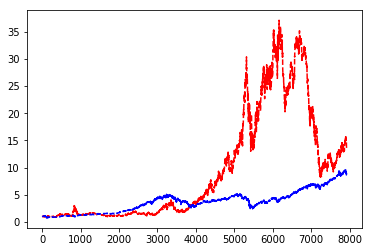

In [7]:
import matplotlib.pyplot as plt
strat = test_single_investment()[2]
sp500 = test_asset(0)[1]
plt.plot(strat, 'r--', sp500, 'b--')
plt.show()